<a href="https://colab.research.google.com/github/Surendra962/Gesture_Recognition/blob/main/Gesture_Recognition_Upgrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

**Working Group of:**


1.   Surendra Mehta
2.   Daksha Kanungo
3.   SHASHANK KUMAR PANDEY 








In [1]:
#mount colab zip file
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing the required libraries
import numpy as np
import os
import cv2
import datetime
import os
import imageio
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,  Dropout, LSTM, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
!pip install pillow # install pillow for image processing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We set the random seed so that the results don't vary drastically.

In [4]:
# fix random seed for reproducibility
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# unzip the images and other data
# !unzip -u 'gdrive/My Drive/Upgrad/gesture_reco/Project_data.zip' -d 'gdrive/My Drive/Upgrad/gesture_reco/photos'

In [5]:
# path of the train and test files and levels

train_doc = np.random.permutation(open('gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val.csv').readlines())
# this batch size i will give assign with other variable
batch_size = 20 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
x = 18 # Number of images in each video
y = 80 # height of the image that will be fed to the model
z = 80 # width of the image that will be fed to the model
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(6, 24)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z ,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[0]>120:
                        img_crop = image[75:-75, 50:-50, :] # Cropping for 360X360
                    else:
                        img_crop = image[25:-25, 30:-30, :] # Cropping for 120X160
                    
                    final_image = resize(img_crop, (y, z, 3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder, idx, :,:,:] = final_image
                    batch_data[folder,idx,:,:,0] = batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB x,y,z = 18,84,84
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    if image.shape[0]>120:
                        img_crop = image[75:-75, 50:-50, :]
                    else:
                        img_crop = image[25:-25, 30:-30, :]
                    
                    final_image = resize(img_crop, (y, z, 3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder, idx, :,:,:] = final_image
                    
                    batch_data[folder,idx,:,:,0] = batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

  

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train'
val_path = 'gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

<h2><span style="color:red">1st Model</span></h2>

#### This is a convlutional 3d model, with batch size of 32, 20 epochs, 80x80 image size

In [ ]:
#1st Model conv3d
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding="same", input_shape=(x,y,z,3))) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
model.add(BatchNormalization()) # Batch normalization layer
model.add(Activation("elu")) # Activation layer
model.add(MaxPooling3D(pool_size=(2,2,2))) # Max pooling layer

model.add(Conv3D(64, (3,3,3), padding="same")) # Convolution layer
model.add(BatchNormalization()) # Batch normalization layer
model.add(Activation("elu")) # Activation layer
model.add(MaxPooling3D(pool_size=(3,4,4))) # Max pooling layer

model.add(Flatten()) # Flatten layer to convert the data to 1D
model.add(Dense(192, activation="relu")) # Dense layer
model.add(Dropout(0.35)) # Dropout layer to avoid overfitting
model.add(Dense(5, activation="softmax")) # Dense layer with softmax activation

In [ ]:
#1st Model conv3d
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.9) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 80, 80, 32)    2624      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 80, 80, 32)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 40, 40, 64)     55360     
                                                                 
 batch_normalization_9 (Batc  (None, 9, 40, 40, 64)   

In [ ]:
#1st Model conv3d
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
##1st Model conv3d
print("Number of images in train set: ", len(train_doc))
print("Number of images in validation set: ", len(val_doc))
print("Batch size: ", batch_size)
print("Number of steps per epoch: ", len(train_doc)//batch_size)
print("Number of validation steps: ", len(val_doc)//batch_size)



Number of images in train set:  663
Number of images in validation set:  100
Batch size:  20
Number of steps per epoch:  33
Number of validation steps:  5


In [ ]:
#1st Model conv3d
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
model_name = 'Gesture_Rec_FInal' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
#1st Model conv3d
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#1st Model conv3d
model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.8155 - categorical_accuracy: 0.2866 Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 2.45573, saving model to Gesture_Rec_FInal_2023-03-1913_26_07.134126/model-00001-2.81548-0.28658-2.45573-0.19000.h5
34/34 [==============================] - 736s 22s/step - loss: 2.8155 - categorical_accuracy: 0.2866 - val_loss: 2.4557 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.3626 - categorical_accuracy: 0.4072 
Epoch 2: val_loss improved from 2.45573 to 1.82787, saving model to Gesture_Rec_FInal_2023-03-1913_26_07.134126/model-00002-1.36261-0.40724-1.82787-0.22000.h5
34/34 [==============================] - 730s 22s/step - loss: 1.3626 - categorical_accuracy: 0.4072 - val_loss: 1.8


<h2><span style="color:red">2nd Model</span></h2>

#### In this model we have used 30 frames with 100*100 image size and 64,128,256,256 filters and 512 dense layer with 5 output classes with 20 epochs and batch size 30

In [ ]:
#2nd Model conv3d
class canva3d_model():
    
    def Model3D(self,fr_to_sample,image_height,image_width):
        
        model = Sequential()
        model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(fr_to_sample,image_height,image_width,3)))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

        model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        # model.add(Dropout(0.25))

        model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        # model.add(Dropout(0.25))

        model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        model.add(Flatten())

        model.add(Dropout(0.5))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
                
        optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
#Global vars
def global_vars(img_idx,shape_h,shape_w,batch_size,num_epochs):
    print("the number of images we will be feeding in the input for a video {}".format(len(img_idx)))
    return img_idx,shape_h,shape_w,batch_size,num_epochs

In [ ]:
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,5)),100,100,30,20)
conv_model2 = Conv3DModel()
model = conv_model2.canva3d_model(fr_to_sample=len(img_idx),img_hight=shape_h,img_width=shape_w)
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


the number of images we will be feeding in the input for a video 6
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 6, 100, 100, 64)   5248      
                                                                 
 batch_normalization_44 (Bat  (None, 6, 100, 100, 64)  256       
 chNormalization)                                                
                                                                 
 activation_44 (Activation)  (None, 6, 100, 100, 64)   0         
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 3, 50, 100, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 3, 50, 100, 128)   221312    
                                                    

Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 30


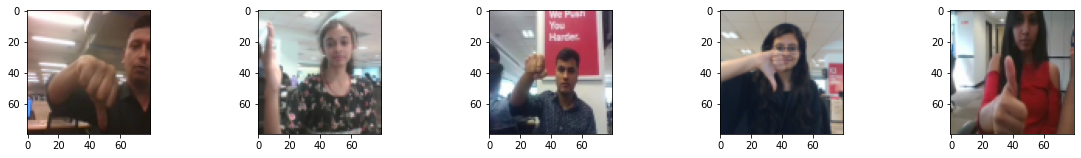

In [ ]:
#2nd Model conv3d
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(20, 5))
for image ,levels in generator(train_path, train_doc, batch_size):
    for i in range(0, 5):
        plt.subplot(2, 5, i+1)
        plt.imshow(image[i][0])
    break
plt.show()

In [ ]:
#2nd Model conv3d
print("Number of images in train set: ", len(train_doc))
print("Number of images in validation set: ", len(val_doc))
print("Batch size: ", batch_size)
print("Number of steps per epoch: ", len(train_doc)//batch_size)
print("Number of validation steps: ", len(val_doc)//batch_size)


model_name = 'Gesture_Rec_FInal' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

# LR code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,  min_lr=0.00001)
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    


model2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<h2><span style="color:red">3rd Model</span></h2>

####  3d conv layer with 64,128,256,256 filters , epoch 20 and batch size 20

In [ ]:
#3rd Model conv3d
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,5)),50,50,20,20)
conv_model2 = Conv3DModel()
model = conv_model2.canva3d_model(fr_to_sample=len(img_idx),img_hight=shape_h,img_width=shape_w)
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


the number of images we will be feeding in the input for a video 6
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 6, 50, 50, 64)     5248      
                                                                 
 batch_normalization_4 (Batc  (None, 6, 50, 50, 64)    256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 6, 50, 50, 64)     0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 25, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 25, 50, 128)    221312    
                                                     

Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20


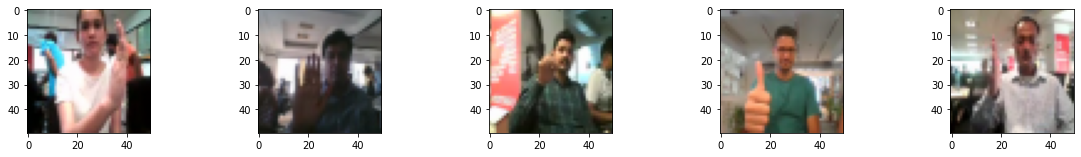

In [ ]:
#3rd Model conv3d
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(20, 5))
for image ,levels in generator(train_path, train_doc, batch_size):
    for i in range(0, 5):
        plt.subplot(2, 5, i+1)
        plt.imshow(image[i][0])
    break
plt.show()

In [ ]:
print("Number of images in train set: ", len(train_doc))
print("Number of images in validation set: ", len(val_doc))
print("Batch size: ", batch_size)
print("Number of steps per epoch: ", len(train_doc)//batch_size)
print("Number of validation steps: ", len(val_doc)//batch_size)


model_name = 'Gesture_Rec_FInal' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

# LR code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,  min_lr=0.00001)
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    


model2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Number of images in train set:  663
Number of images in validation set:  100
Batch size:  20
Number of steps per epoch:  33
Number of validation steps:  5
Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.6880 - categorical_accuracy: 0.3836 Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 3.92271, saving model to Gesture_Rec_FInal_2023-03-1805_11_02.334565/model-00001-2.68801-0.38363-3.92271-0.16000.h5
34/34 [==============================] - 1997s 60s/step - loss: 2.6880 - categorical_accuracy: 0.3836 - val_loss: 3.9227 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4742 - categorical_accuracy: 0.5294 
Epoch 2: val_loss did not improve from 3.92271
34/34 [==============================] - 1632s 49s/step - loss: 1.47

<h2><span style="color:red">4th Model</span></h2>

# in this model we have used image size of 50x50 and 20 epochs and batch size of 20

In [6]:

def generator_1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    while True:
        #Shuffle the list of the folders in csv
        t = np.random.permutation(folder_list)
         #Exact batches of the batch size
        num_batches = int(len(t)/batch_size)
         #Left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (shape_h,shape_w))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                #Fill the one hot encoding stuff where we maintain the label
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

             # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches): 
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) 
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5)) 
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        
                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (shape_h,shape_w))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                        batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123
                        
                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [7]:
#write your model here
class canva3d_model():
    
    def Model3D(self,fr_to_sample,image_height,image_width):
        
        model = Sequential()
        model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(fr_to_sample,image_height,image_width,3)))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

        model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        # model.add(Dropout(0.25))

        model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        # model.add(Dropout(0.25))

        model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

        model.add(Flatten())

        model.add(Dropout(0.5))
        model.add(Dense(512, activation='elu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
                
        optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train'
val_path = 'gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [11]:

img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,5)),50,50,20,20)
conv_mode4 = canva3d_model()
model = conv_mode4.Model3D(fr_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
model.summary()


train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

the number of images we will be feeding in the input for a video 6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 6, 50, 50, 64)     5248      
                                                                 
 batch_normalization (BatchN  (None, 6, 50, 50, 64)    256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 6, 50, 50, 64)     0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 25, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 25, 50, 128)    221312    
                                                       

Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20


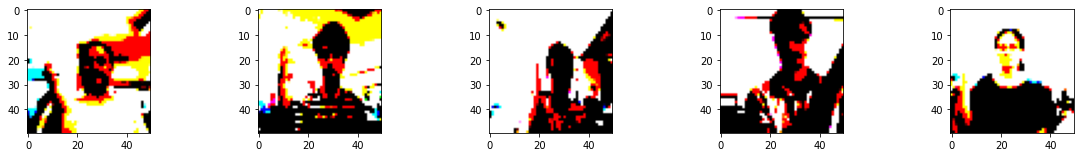

In [ ]:

import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(20, 5))
for image ,levels in generator_1(train_path, train_doc, batch_size):
    for i in range(0, 5):
        plt.subplot(2, 5, i+1)
        plt.imshow(image[i][0])
    break
plt.show()

In [ ]:

print("Number of images in train set: ", len(train_doc))
print("Number of images in validation set: ", len(val_doc))
print("Batch size: ", batch_size)
print("Number of steps per epoch: ", len(train_doc)//batch_size)
print("Number of validation steps: ", len(val_doc)//batch_size)


model_name = 'Gesture_Rec_FInal' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

# LR code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,  min_lr=0.00001)
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    


model2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Number of images in train set:  663
Number of images in validation set:  100
Batch size:  20
Number of steps per epoch:  33
Number of validation steps:  5
Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.5546 - categorical_accuracy: 0.3368 Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 6.75372, saving model to Gesture_Rec_FInal_2023-03-1809_13_43.236122/model-00001-2.55457-0.33676-6.75372-0.23000.h5
34/34 [==============================] - 634s 19s/step - loss: 2.5546 - categorical_accuracy: 0.3368 - val_loss: 6.7537 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.7367 - categorical_accuracy: 0.4794 
Epoch 2: val_loss improved from 6.75372 to 3.61434, saving model to Gesture_Rec_FInal_2023-03-1809_13_43.236122/model-00

<h2><span style="color:red">Model5 : Conv3D</span></h2>

####Conva 3D Model with epoch 20 and batch size 30 and image size 80*80 and frame to sample 2 to 25 with step 4

In [ ]:
def generator_2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    while True:
        #Shuffle the list of the folders in csv
        t = np.random.permutation(folder_list)
         #Exact batches of the batch size
        num_batches = int(len(t)/batch_size)
         #Left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (shape_h,shape_w))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])-108
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 125
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 125

                #Fill the one hot encoding stuff where we maintain the label
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

             # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches): 
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) 
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5)) 
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        
                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (shape_h,shape_w))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 225
                        batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 225
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 225
                        
                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train'
val_path = 'gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
#model-5
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(2,26,4)),80,80,30,20)
conv_mode4 = canva3d_model()
model = conv_mode4.Model3D(fr_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
model.summary()


train_generator = generator_2(train_path, train_doc, batch_size)
val_generator = generator_2(val_path, val_doc, batch_size)

the number of images we will be feeding in the input for a video 6
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 6, 80, 80, 64)     5248      
                                                                 
 batch_normalization_24 (Bat  (None, 6, 80, 80, 64)    256       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 6, 80, 80, 64)     0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 3, 40, 80, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 3, 40, 80, 128)    221312    
                                                     

Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 30


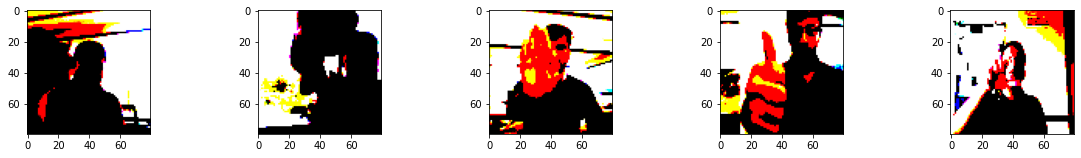

In [ ]:
#model-5
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(20, 5))
for image ,levels in generator_1(train_path, train_doc, batch_size):
    for i in range(0, 5):
        plt.subplot(2, 5, i+1)
        plt.imshow(image[i][0])
    break
plt.show()

In [ ]:
#model-5
print("Number of images in train set: ", len(train_doc))
print("Number of images in validation set: ", len(val_doc))
print("Batch size: ", batch_size)
print("Number of steps per epoch: ", len(train_doc)//batch_size)
print("Number of validation steps: ", len(val_doc)//batch_size)


model_name = 'Gesture_Rec_FInal' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

# LR code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,  min_lr=0.00001)
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

    


model5=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Number of images in train set:  663
Number of images in validation set:  100
Batch size:  30
Number of steps per epoch:  22
Number of validation steps:  3
Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.7579 - categorical_accuracy: 0.3536 Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val ; batch size = 30

Epoch 1: val_loss improved from inf to 6.18944, saving model to Gesture_Rec_FInal_2023-03-1811_33_52.889521/model-00001-2.75795-0.35362-6.18944-0.26667.h5
23/23 [==============================] - 972s 42s/step - loss: 2.7579 - categorical_accuracy: 0.3536 - val_loss: 6.1894 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6042 - categorical_accuracy: 0.5014 
Epoch 2: val_loss did not improve from 6.18944
23/23 [==============================] - 958s 42s/step - loss: 1.6042 - c

<h2><span style="color:red">Model-6 : CONV2D + GRU</span></h2>

In [ ]:
def generator_2d(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    while True:
        #Shuffle the list of the folders in csv
        t = np.random.permutation(folder_list)
         #Exact batches of the batch size
        num_batches = int(len(t)/batch_size)
         #Left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (shape_h,shape_w))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255

                #Fill the one hot encoding stuff where we maintain the label
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

             # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches): 
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3)) 
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5)) 
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        
                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (shape_h,shape_w))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) /255
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255
                        
                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
img_idx,shape_h,shape_w,batch_size,num_epochs = global_vars(list(range(0,30,4)),100,100,20,20)

the number of images we will be feeding in the input for a video 8


In [ ]:
#model-6

from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D

model=Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),input_shape=(len(img_idx),shape_h, shape_w,3)))
# add batch normalization
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))

# add batch normalization
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
# add batch normalization
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
# add batch normalization
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(128,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 100, 100, 16)  448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 100, 100, 16)  64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 8, 50, 50, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 8, 50, 50, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 8, 50, 50, 32)   

In [ ]:


train_generator = generator_2d(train_path, train_doc, batch_size)
val_generator = generator_2d(val_path, val_doc, batch_size)

Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20


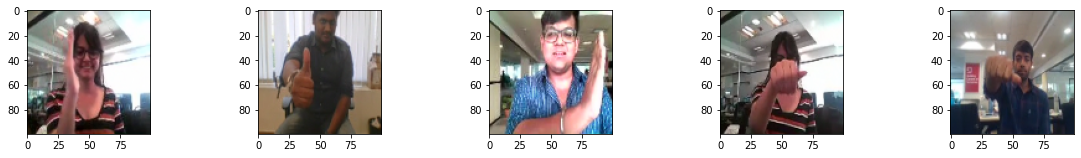

In [ ]:
#model-6
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(20, 5))
for image ,levels in generator_2d(train_path, train_doc, batch_size):
    for i in range(0, 5):
        plt.subplot(2, 5, i+1)
        plt.imshow(image[i][0])
    break
plt.show()

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

  

In [ ]:
Model6=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7776 - categorical_accuracy: 0.3529 Source path =  gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 3.11765, saving model to Gesture_Rec_FInal_2023-03-1903_39_52.289044/model-00001-1.77759-0.35294-3.11765-0.17000.h5
34/34 [==============================] - 1553s 47s/step - loss: 1.7776 - categorical_accuracy: 0.3529 - val_loss: 3.1176 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2561 - categorical_accuracy: 0.5103
Epoch 2: val_loss did not improve from 3.11765
34/34 [==============================] - 168s 5s/step - loss: 1.2561 - categorical_accuracy: 0.5103 - val_loss: 4.0813 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s -

<h2><span style="color:red">Model-7 : MobileNet and GRU layers</span></h2>

In [25]:
import imageio
import abc

project_folder='gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data'

class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta): # Abstract class
    # same above code written in function for augmentation
    
    def initialize_path(self,project_folder): # Initialize the path for the project
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines()) # read the training data
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines()) # read the validation data
        self.train_path = project_folder + '/' + 'train' # store the training data path
        self.val_path =  project_folder + '/' + 'val'# store the validation data path
        self.num_train_sequences = len(self.train_doc) # get the number of training sequences
        self.num_val_sequences = len(self.val_doc) # get the number of validation sequences
        
    def initialize_image_properties(self,image_height=100,image_width=100): # Initialize the image properties
        self.image_height=image_height # set the image height
        self.image_width=image_width # set the image width
        self.channels=3 # set the number of channels        
        self.num_classes=5 # set the number of classes
        self.total_frames=30 # set the total number of frames
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20): # Initialize the hyperparameters
        self.frames_to_sample=frames_to_sample # set the number of frames to sample
        self.batch_size=batch_size # set the batch size
        self.num_epochs=num_epochs # set the number of epochs
        
        
    def generator(self,source_path, folder_list, augment=False): # Define the generator
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int) # create a list of image numbers you want to use for a particular video
        batch_size=self.batch_size # set the batch size
        while True: # loop over the folder_list
            t = np.random.permutation(folder_list) # get the list of all the images from the folder_list
            num_batches = len(t)//batch_size # calculate the number of batches
        
            for batch in range(num_batches):  # we iterate over the number of batches
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment) # read the image and get the image array
                yield batch_data, batch_labels  #you yield the batch_data and the batch_labels, remember what does yield do

            remaining_seq=len(t)%batch_size # iterate over the remaining sequence
        
            if (remaining_seq != 0): # for the remaining batch, the batch size will be equal to the remaining sequence
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0): # Define the one batch data function
    
        seq_len = remaining_seq if remaining_seq else batch_size # get the sequence length
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))  # create a numpy array of size (batch_size,frames_to_sample,image_height,image_width,channels)
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod # abstract method
    def define_model(self): # abstract method
        pass 

In [17]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class mobilenet_1(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=128,dense_neurons=128,dropout=0.25):
        
        model = Sequential() # define model
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels))) # add model
 
        
        model.add(TimeDistributed(BatchNormalization())) # add batch normalization layer
        model.add(TimeDistributed(MaxPooling2D((2, 2)))) # add pooling layer
        model.add(TimeDistributed(Flatten())) # add flatten layer

        model.add(GRU(128)) # add GRU layer
        model.add(Dropout(0.25)) # add dropout layer
        
        model.add(Dense(128,activation='relu')) # add dense layer
        model.add(Dropout(0.25)) # add dropout layer
        
        model.add(Dense(self.num_classes, activation='softmax')) # add output layer
        
        
        optimiser = optimizers.Adam() # define optimiser
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy']) # compile model
        return model # return model
    

In [18]:
project_folder='gdrive/My Drive/Upgrad/gesture_reco/photos/Project_data'

In [20]:
model_6=mobilenet_1()
model_6.initialize_path(project_folder)
model_6.initialize_image_properties(image_height=120,image_width=120)
model_6.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
model_6_model=model_6.define_model()
model_6_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)              

In [ ]:
model6=model_6.train_model(model_6_model,augment_data=True)

Total Params: 3693253


<ipython-input-86-d9801350ba33>:131: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1187 - categorical_accuracy: 0.5543 
Epoch 1: saving model to model_init_2023-03-2015_42_26.824739/model-00001-1.11866-0.55430-0.55925-0.76000.h5
133/133 [==============================] - 3481s 26s/step - loss: 1.1187 - categorical_accuracy: 0.5543 - val_loss: 0.5593 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6104 - categorical_accuracy: 0.7722 
Epoch 2: saving model to model_init_2023-03-2015_42_26.824739/model-00002-0.61041-0.77225-0.75790-0.73000.h5
133/133 [==============================] - 2083s 16s/step - loss: 0.6104 - categorical_accuracy: 0.7722 - val_loss: 0.7579 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4720 - categorical_accuracy: 0.8258 
Epoch 3: saving model to model_init_2023-03-2015_42_26.824739/model-00003-0.47196-0.82579-0.40523-0.87000.h5
133/

# For the solution of gesture recognition project, we builed and tested 7 model as follows:
**Conv3D**



> Model-1:  *In this model total number of epochs is 30 and batch size is 20 , filters are 32 and 64 and kernel size is 3*3*3* 

*   Filter used in the model: 16,32,64,128  SGD optimizer
*   Accuracy: 74%
*   Validation Accuracy:46%
*   Remarks: This is a good model of all

> Model-2:  *This is also a convolutional 3d model, with 64,128,256,256 filters , epoch 20 and batch size 20* 
*   not running overflow

*  Model-3:  Filter used in the model: 64, 128, 256, 256 ,dense layer 512 with SGD optimizer
*   Accuracy: 96%
*   Validation Accuracy: 67%
*   Remarks: This model is overfitting


> Model-4:  *This is also a convolutional 3d model, with 64,128,256,256 filters , epoch 20 and batch size 20* 

*   Filter used in the model: 64, 128, 256, 256 ,dense layer 512 with SGD optimizer
*   Accuracy:  89%
*   Validation Accuracy: 71%
*   Remarks: Good result still overfitting 

> Model-5:  *This is also a convolutional 3d model, with epoch 20 and batch size 30 and image size 80*80 * 

*   Filter used in the model: 64, 128, 256, 256 ,dense layer 512 with SGD optimizer
*   Accuracy:  90%
*   Validation Accuracy: 59%
*   Remarks: This is also a overfitting model

**CONV2D + GRU**

> Model-6:  *This is a Convoluational 2D + GRU model, In this model we are using image size of 100x100 and 30 frames with batch size of 20 and 20 epochs* 

*   Filter used in the model: 16,32,64,128  SGD optimizer
*   Accuracy:  97%
*   Validation Accuracy: 74%
*   Remarks: This is also a overfitting model

**MobileNet and GRU layers**

> Model-7:  *This is a mobileNet + GRU model, In this model we are using image size of 100x100 and 30 frames with batch size of 20 and 20 epochs*

*   Filter used in the model: 16,32,64,128  SGD optimizer
*   Accuracy:  88%
*   Validation Accuracy: 91%
*   Remarks: This is a good model but not completed all epoch due to less recources

Test the saved model

In [29]:
import time
from keras.models import load_model
model = load_model('gdrive/My Drive/Upgrad/model-00003-0.47196-0.82579-0.40523-0.87000.h5')

In [31]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 128)             

In [32]:
model.get_weights()

[array([[[[ 8.87084053e-14,  2.99252868e-01,  1.83268962e-03,
            1.65614850e-13,  1.67507152e-14,  2.42102280e-01,
           -2.42544279e-01, -3.02693218e-01, -4.32953903e-15,
            9.24046412e-02,  3.83687407e-01,  9.35078702e-14,
            1.36196494e-01,  1.70400560e-01,  1.26218712e-02,
           -5.67753147e-03, -5.14434686e-13, -1.58579886e-01,
            4.16608840e-01, -2.71822184e-01,  1.27436947e-13,
            8.86099631e-15, -6.02695495e-02,  2.71239787e-01,
            5.91953378e-03,  1.29303299e-02,  3.08230668e-01,
           -1.83601603e-01, -5.61670840e-01,  2.55615473e-01,
           -4.12201762e-01,  2.54807714e-03],
          [ 1.05321493e-13, -3.62965077e-01,  2.74118949e-02,
            1.44252747e-13,  5.91760866e-14,  1.74299836e-01,
           -1.18767999e-01,  9.48182046e-02,  8.52340540e-15,
           -1.79428086e-01,  3.76071990e-01,  1.19941383e-13,
            1.34417474e-01,  1.89512983e-01,  2.78790202e-02,
           -5.61951939e-

In [33]:
# show the model configuration
model.get_config()

{'name': 'sequential_13',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 16, 120, 120, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'time_distributed_38_input'}},
  {'class_name': 'TimeDistributed',
   'config': {'name': 'time_distributed_38',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 16, 120, 120, 3),
    'layer': {'class_name': 'Functional',
     'config': {'name': 'mobilenet_1.00_224',
      'layers': [{'class_name': 'InputLayer',
        'config': {'batch_input_shape': (None, None, None, 3),
         'dtype': 'float32',
         'sparse': False,
         'ragged': False,
         'name': 'input_16'},
        'name': 'input_16',
        'inbound_nodes': []},
       {'class_name': 'Conv2D',
        'config': {'name': 'conv1',
         'trainable': True,
         'dtype': 'float32',
         'filters': 32,
         'kernel_size': (3, 3),
         'strides': (2, 2),
         'p